In [ ]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting seeds for reproducibility
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE
import pandas as pd
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
data_file_path = "/content/drive/MyDrive/protein_props/features/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/druggable_proteins.txt"
investigational_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/investigational_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))

# Extracting list of druggable and approved druggable proteins
with open(druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

with open(investigational_proteins_file_path, 'r') as f:
    investigational_proteins = f.read().splitlines()

druggable_proteins = approved_druggable_proteins + investigational_proteins

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of druggable approved proteins:", len(approved_druggable_proteins))


# Fetching feature data for all proteins
properties = (pd.read_json("/content/drive/MyDrive/protein_props/features/protein_props.json")).transpose()
is_druggable = [1 if i in druggable_proteins else 0 for i in properties.index]
is_approved_druggable = [1 if i in approved_druggable_proteins else 0 for i in properties.index]

properties["is_druggable"] = is_druggable
properties["is_approved_druggable"] = is_approved_druggable

PCP_properties = properties.copy()
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {i:[] for i in amino_acids}
for i in PCP_properties['Amino Acid Percent']:
  for aa in amino_acids:
    amino_acid_percent[aa].append(i[aa])
for aa in amino_acids:
  PCP_properties = pd.concat([PCP_properties, pd.Series(amino_acid_percent[aa], index = PCP_properties.index, name = f"Amino Acid Percent {aa}")], axis = 1)

PCP_properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)
PCP_properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)

PCP_properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)

PCP_properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_properties['Sequence Length'] = PCP_properties['Sequence Length'].astype(int)
PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

with open("/content/drive/MyDrive/protein_props/features/gdpc_encodings.json", 'r') as file:
    data = json.load(file)
gpdc_encodings = pd.DataFrame(data).transpose()

ppi = pd.read_json("/content/drive/MyDrive/protein_props/features/ppi.json").transpose()
ppi_network = pd.read_csv("/content/drive/MyDrive/protein_props/features/ppi_network_properties.csv")
ppi_network.index = ppi_network['Unnamed: 0']
ppi_network.drop(columns = ['Unnamed: 0'], inplace = True)
ppi = pd.concat([ppi, ppi_network], axis = 1)

glycolisation = pd.read_csv("/content/drive/MyDrive/protein_props/features/glycosylation.csv")
glycolisation.index = glycolisation['Unnamed: 0']
glycolisation.drop(columns = ['Unnamed: 0'], inplace = True)
ptm = pd.read_csv("/content/drive/MyDrive/protein_props/features/PTM_counts.csv")
ptm.index = ptm["Unnamed: 0"]
ptm.drop(columns = ['Unnamed: 0'], inplace = True)
ptm_counts = pd.concat([ptm, glycolisation], axis = 1)

with open("/content/drive/MyDrive/protein_props/features/subcellular_locations2.json", 'r') as file:
    data = json.load(file)
unique_groups = set()
for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry: unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

rows = []
for protein_id in PCP_properties.index:
    row = {group: 0 for group in unique_groups_list}
    if protein_id in data:
        for entry in data[protein_id].get("general", []):
            if "group" in entry and entry["group"] in unique_groups:
                row[entry["group"]] = 1
    row["protein_id"] = protein_id
    rows.append(row)

subcellular_data = pd.DataFrame(rows).set_index("protein_id")

domains = pd.read_csv("/content/drive/MyDrive/protein_props/features/data_top20_updated.csv")
domains.index = domains['Unnamed: 0']
domains.drop(columns = ['Unnamed: 0'], inplace = True)

flexibility = pd.read_csv("/content/drive/MyDrive/protein_props/features/flexibility_properties.csv")
flexibility.index = flexibility['Unnamed: 0']
flexibility.drop(columns = ['Unnamed: 0'], inplace = True)

latent_data = pd.read_csv("/content/drive/MyDrive/protein_props/features/latent_values.csv").transpose()
latent_data.columns = [f"Latent_Value_{i+1}" for i in latent_data.columns]
final_data = pd.concat([PCP_properties,gpdc_encodings, ptm_counts, ppi, subcellular_data, domains, flexibility, latent_data], axis = 1).dropna()
features_list = final_data.columns
features_list = features_list.drop(['is_druggable','is_approved_druggable'])
features_list = list(features_list)
print(features_list)
print(len(features_list))


Total number of uniprot human verified proteins: 20434
Number of druggable proteins: 2915
Number of druggable approved proteins: 2233
['Sequence Length', 'Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7', 'Amino Acid Percent A', 'Amino Acid Percent C', 'Amino Acid Percent D', 'Amino Acid Percent E', 'Amino Acid Percent F', 'Amino Acid Percent G', 'Amino Acid Percent H', 'Amino Acid Percent I', 'Amino Acid Percent K', 'Amino Acid Percent L', 'Amino Acid Percent M', 'Amino Acid Percent N', 'Amino Acid Percent P', 'Amino Acid Percent Q', 'Amino Acid Percent R', 'Amino Acid Percent S', 'Amino Acid Percent T', 'Amino Acid Percent V', 'Amino Acid Percent W', 'Amino Acid Percent Y', 'Molar Extinction Coefficient 1', 'Molar Extinction Coefficient 2', 'Secondary Structure helix', 'Secondary Structure turn', 'Secondary Structure sheet', 'aliphatic_aliphatic', 'aliphatic_positive', 'aliphatic_negative', 'aliphatic_uncharged', 'aliphatic_aromatic',

In [ ]:
# Train Test Splitting
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE

def get_data(x_sample, y_sample):
  return np.array(x_sample), np.array(y_sample)

def data_splitting(x_sample, y_sample, mode="default", scaler="none", class_size=600):
  druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
  non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

  druggable_X = x_sample[druggable_indices]
  druggable_y = y_sample[druggable_indices]

  non_druggable_X = x_sample[non_druggable_indices]
  non_druggable_y = y_sample[non_druggable_indices]

  druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
  non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size= class_size, random_state=123)

  X_test = pd.concat((druggable_X_test, non_druggable_X_test))
  y_test = pd.concat((druggable_y_test, non_druggable_y_test))
  X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
  y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))
  X_train, y_train = shuffle(X_train, y_train, random_state=123)
  if mode == "default":
    pass
  elif mode == "adasyn":
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_resample(X_train, y_train)
  elif mode == "smote":
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_resample(X_train, y_train)

  if scaler == "std":
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "minmax":
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "none":
    pass

  return X_train, X_test, y_train, y_test


In [ ]:
# rem-new-data is to extract only those proteins which are either approved druggable or non-druggable
# i.e., it excludes proteins which are non-approved but druggable
new_data = final_data.copy()
new_data['new_column'] = new_data['is_druggable'] + new_data['is_approved_druggable']
rem_new_data = new_data[new_data['new_column'] != 1]
rem_new_data.shape, np.bincount(rem_new_data['new_column'])

((19596, 186), array([17377,     0,  2219]))

In [ ]:
X_train, X_test, y_train, y_test = data_splitting(rem_new_data[features_list], rem_new_data['is_druggable'], class_size=300)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18996, 183), (600, 183), (18996,), (600,))

In [ ]:
# Distribution of classes in train and test sets
np.bincount(y_train), np.bincount(y_test)

(array([17077,  1919]), array([300, 300]))

### Majority Prediction of Partitions

In [ ]:
X_train_druggable = X_train[y_train == 1]
X_train_non_druggable = X_train[y_train == 0]

X_train_non_druggable_partitions = np.array_split(X_train_non_druggable, round(len(X_train_non_druggable)/len(X_train_druggable)))
print(f"Splitting into {len(X_train_non_druggable_partitions)} partitions")
print("Sizes of partitions")
for i, partition in enumerate(X_train_non_druggable_partitions):
  print(f"Partition {i}: {len(partition)}")

Splitting into 9 partitions
Sizes of partitions
Partition 0: 1898
Partition 1: 1898
Partition 2: 1898
Partition 3: 1898
Partition 4: 1897
Partition 5: 1897
Partition 6: 1897
Partition 7: 1897
Partition 8: 1897


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
import xgboost as xgb

xgb_models = []
for i, partition in enumerate(X_train_non_druggable_partitions):
  print(f"Training model for partition {i}")
  X_combined = np.concatenate((X_train_druggable, partition))
  y_combined = np.concatenate((np.ones(len(X_train_druggable)), np.zeros(len(partition))))
  xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
  xgb_model.fit(X_combined, y_combined)
  xgb_models.append(xgb_model)


Training model for partition 0
Training model for partition 1
Training model for partition 2
Training model for partition 3
Training model for partition 4
Training model for partition 5
Training model for partition 6
Training model for partition 7
Training model for partition 8


In [ ]:
y_preds = []
for model in xgb_models:
  y_pred = model.predict(X_test)
  y_preds.append(y_pred)

majority_preds = np.mean(y_preds, axis=0)
majority_preds = np.round(majority_preds)
majority_preds.shape

(600,)

In [ ]:
y_pred_probas = []
for model in xgb_models:
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred_probas.append(y_pred_proba)

y_pred_probas = np.array(y_pred_probas)
mean_pred_probas = np.mean(y_pred_probas, axis=0)
average_proba_preds = np.round(mean_pred_probas)
y_pred_probas.shape, mean_pred_probas.shape, average_proba_preds.shape

((9, 600), (600,), (600,))

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_metrics = {}
for i, y_pred in enumerate(y_preds):
  accuracy_metrics[f"partition_{i}"]={
      "accuracy_total": accuracy_score(y_test, y_pred),
      "accuracy_druggable": accuracy_score(y_test[y_test == 1], y_pred[y_test == 1]),
      "accuracy_non_druggable": accuracy_score(y_test[y_test == 0], y_pred[y_test == 0]),
  }
  accuracy_metrics["majority_prediction"]={
      "accuracy_total": accuracy_score(y_test, majority_preds),
      "accuracy_druggable": accuracy_score(y_test[y_test == 1], majority_preds[y_test == 1]),
      "accuracy_non_druggable": accuracy_score(y_test[y_test == 0], majority_preds[y_test == 0]),
  }
  accuracy_metrics["average_probability_prediction"] = {
      "accuracy_total": accuracy_score(y_test, average_proba_preds),
      "accuracy_druggable": accuracy_score(y_test[y_test == 1], average_proba_preds[y_test == 1]),
      "accuracy_non_druggable": accuracy_score(y_test[y_test == 0], average_proba_preds[y_test == 0]),
  }


df = pd.DataFrame(accuracy_metrics).transpose()
df

,accuracy_total,accuracy_druggable,accuracy_non_druggable
partition_0,0.758333,0.770000,0.746667
majority_prediction,0.776667,0.793333,0.760000
average_probability_prediction,0.771667,0.800000,0.743333
partition_1,0.761667,0.803333,0.720000
partition_2,0.765000,0.793333,0.736667
partition_3,0.771667,0.786667,0.756667
partition_4,0.778333,0.800000,0.756667
partition_5,0.753333,0.753333,0.753333
partition_6,0.776667,0.770000,0.783333
partition_7,0.765000,0.780000,0.750000


In [ ]:
# df.to_csv("/content/drive/MyDrive/protein_props/NEW_WORK/XGB_PEC_metrics.csv")


### AUC SCORES

0.8738333333333335


([], [])

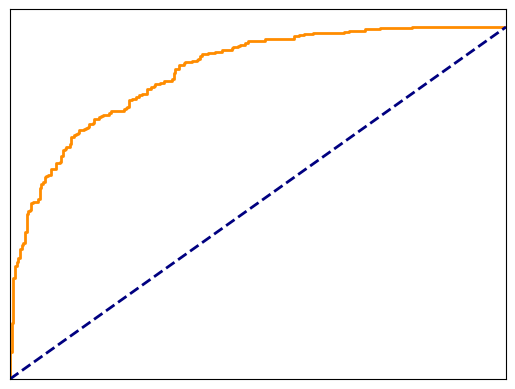

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC_AUC for average_probability_preds
fpr, tpr, thresholds = roc_curve(y_test, mean_pred_probas)
roc_auc = roc_auc_score(y_test, mean_pred_probas)
print(roc_auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# no axis marks
plt.xticks([])
plt.yticks([])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

# plt.savefig("/content/drive/MyDrive/protein_props/NEW_WORK/XGB_PEC_AUC_curve.png")

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, average_proba_preds)
conf_matrix

array([[223,  77],
       [ 60, 240]])

<Axes: >

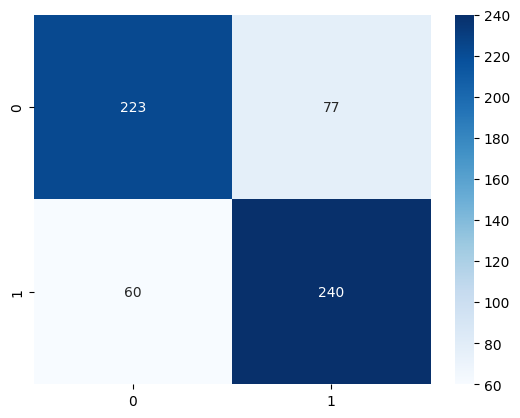

In [ ]:
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt = 'd')
# plt.savefig("/content/drive/MyDrive/protein_props/NEW_WORK/XGB_PEC_confusion_matrix.png")

In [ ]:
# import matplotlib.pyplot as plt
# sns.heatmap(conf_matrix, annot=False, cmap='Blues')
# # plot no xticks and yticks
# plt.xticks([])
# plt.yticks([])
# plt.show()